In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cards-image-datasetclassification


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [ ]:
class Cards (Dataset):
    def __init__(self,data_dir,transform=None):
        self.data =  ImageFolder(data_dir, transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        return self.data[index]
    @property
    def classess(self):
        return self.data.classes



In [ ]:
Cards_train=Cards(data_dir='/kaggle/input/cards-image-datasetclassification/train')
len(Cards_train)

7624

In [ ]:
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
class_index = {}
# Get the class_to_idx mapping
class_to_idx = ImageFolder(data_dir).class_to_idx
for class_name, idx in class_to_idx.items():
    class_index[idx] = class_name

print(class_index)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),])
Cards_train=Cards('/kaggle/input/cards-image-datasetclassification/train',transform)

In [ ]:
img,idx=Cards_train[0]
print(img.shape,idx)

torch.Size([3, 128, 128]) 0


In [ ]:
dataloader = DataLoader(Cards_train, batch_size = 32, shuffle = True)
for images, labels in dataloader:
    break
images.shape, labels.shape,labels


(torch.Size([32, 3, 128, 128]),
 torch.Size([32]),
 tensor([17, 40, 25, 14, 46, 12, 15,  7,  7, 52, 14,  4, 43, 37, 40, 42, 47, 31,
         32, 10, 34, 39, 24, 38, 11, 40,  8, 50, 32, 14, 22, 47]))

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classess = 53):
        super(SimpleCardClassifer, self).__init__() #initialize everything from parent class
        #where we define all parts of model
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280

        #make a classifer:
        self.classifier = nn.Linear(enet_out_size, num_classess)

    def forward(self, x):
        # connect all parts above and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [ ]:

model = SimpleCardClassifer(num_classess=53)

In [ ]:
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [ ]:
example_out = model(images)
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion(example_out, labels)

tensor(4.0390, grad_fn=<NllLossBackward0>)

In [ ]:
train_folder = '/kaggle/input/cards-image-datasetclassification/train'
val_folder = '/kaggle/input/cards-image-datasetclassification/valid'
test_folder = '/kaggle/input/cards-image-datasetclassification/test'

train_dataset = Cards(train_folder, transform=transform)
val_dataset = Cards(val_folder, transform=transform)
test_dataset = Cards(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [ ]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classess=53)
model.to(device)

#create loss function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    #training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc = 'Training loop'):
        # move input and labels to the device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*labels.size(0)
    train_loss = running_loss/len(train_loader.dataset)
    train_losses.append(train_loss)

    #validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            #move input & ouput labels to device
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()*labels.size(0)
    val_loss = running_loss/len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5999531673359346, Validation loss: 0.3616516084041236


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5791681098037351, Validation loss: 0.23002731462694564


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.34901647129001295, Validation loss: 0.12752038082986508


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.25683361313775854, Validation loss: 0.16519634442509346


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.19125064615852122, Validation loss: 0.10323425137771751


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path, transform):
    original_image = Image.open(image_path).convert('RGB')
    image_tensor = transform(original_image).unsqueeze(0) # Add batch dimension
    return original_image, image_tensor

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
    return probabilities

def visualize_predictions(original_image, probabilities, class_names):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(original_image)
    ax.axis('off')

    # Get top 5 predictions
    top_prob, top_catid = torch.topk(probabilities, 5)

    # Create a text box with predictions
    textstr = '\n'.join([f"{class_names[top_catid[i]]}: {top_prob[i].item():.2f}" for i in range(top_prob.size(0))])
    props = dict(boxstyle='round', alpha=0.5, color='wheat')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.show()

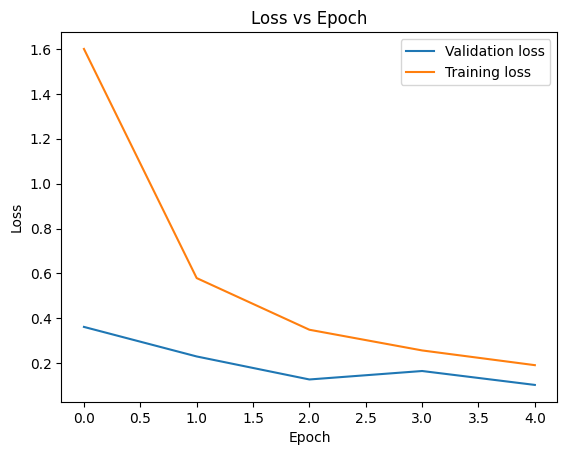

In [ ]:
plt.plot(val_losses, label = 'Validation loss')
plt.plot(train_losses, label = 'Training loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

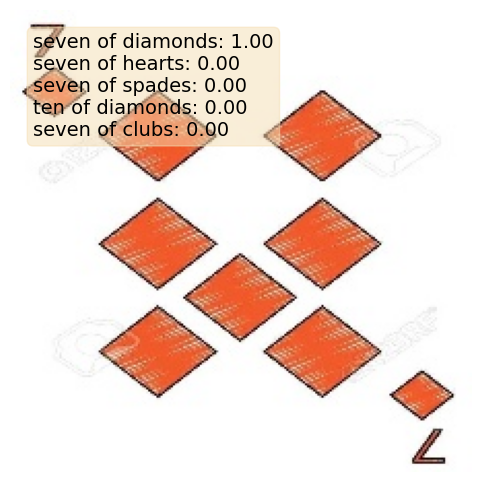

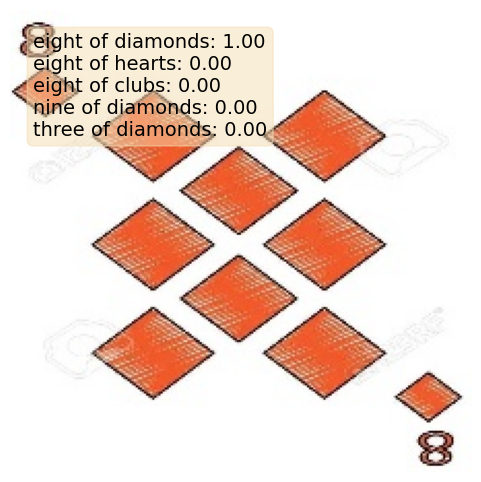

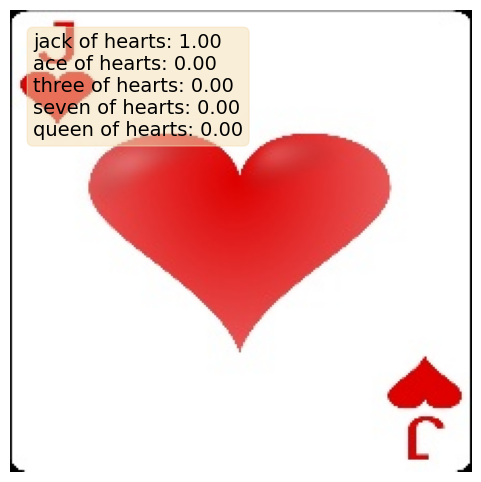

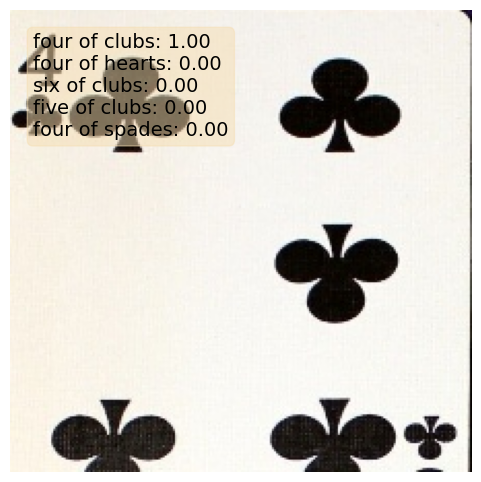

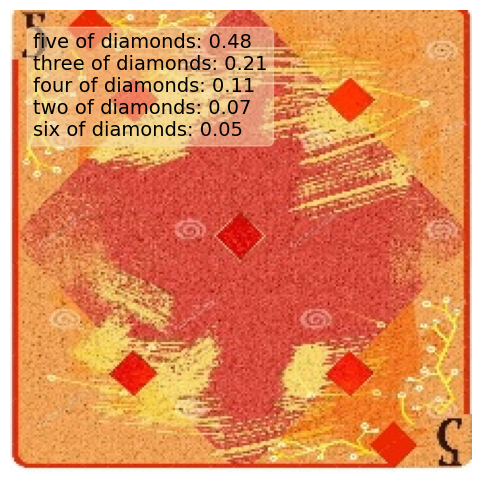

In [ ]:
from glob import glob
test_images=glob('/kaggle/input/cards-image-datasetclassification/test/*/*')
test_set=np.random.choice(test_images,5)

for card_img in test_set:
    original_images,image_tensor = preprocess_image(card_img, transform)
    probabilities=predict(model,image_tensor,device)

    class_names = Cards_train.classess
    visualize_predictions(original_images, probabilities, class_names)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def evaluate_model_with_metrics(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predicted = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='weighted')
    accuracy = 100 * correct / total
    return accuracy, precision, recall, f1

# Evaluate on the test set with additional metrics
accuracy, precision, recall, f1 = evaluate_model_with_metrics(model, test_loader, device)

print(f'Accuracy on the test images: {accuracy:.2f}%')
print(f'Precision on the test images: {precision:.2f}')
print(f'Recall on the test images: {recall:.2f}')
print(f'F1-score on the test images: {f1:.2f}')

Accuracy on the test images: 96.23%
Precision on the test images: 0.97
Recall on the test images: 0.96
F1-score on the test images: 0.96
